In [1]:
import numpy as np
import pandas as pd
import pybrain

In [2]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline
import matplotlib.pylab as pylab
import PIL
pylab.rcParams['figure.figsize']= 16,5

In [3]:
from pybrain import FeedForwardNetwork
from pybrain import LinearLayer,SigmoidLayer
from pybrain import FullConnection
from pybrain.supervised.trainers import BackpropTrainer
from pybrain import datasets

In [4]:
rawData = pd.read_csv('resources/Consulta_Banxico.csv', sep=',', encoding='latin1', skiprows=17, skip_blank_lines=True)
column = rawData.columns.values
rawData
Data = rawData.drop(rawData.index[:2])
Data = Data.reset_index(drop = True)
Data.columns = ['Fecha' , 'Tasa de crecimiento Mensual']

Se eliminan los 2 primeros indices debido a que no son utiles ( es texto y la primera observación no tiene valor) y se crea la estructura de Serie (para la serie de tiempo)

In [5]:
TS = pd.Series(Data['Tasa de crecimiento Mensual'].astype(float))

In [6]:
TS.index= Data['Fecha']

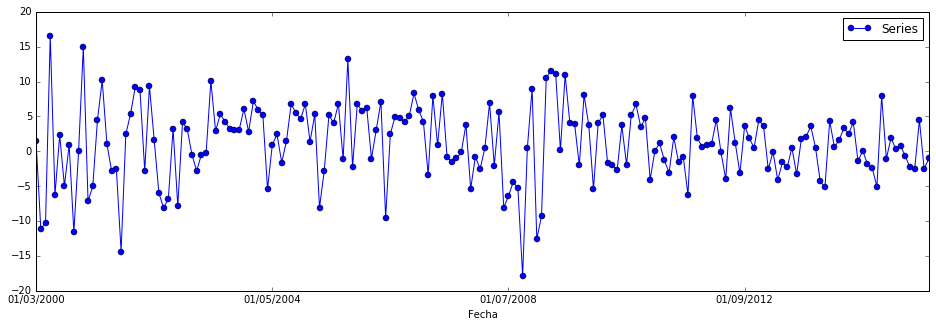

In [7]:
plt.figure()
TS.plot(style='o-', label = 'Series')
plt.legend()

Read from CSV

In [8]:
def read_Data():
    rawData = pd.read_csv('resources/Consulta_Banxico.csv', sep=',', encoding='latin1', skiprows=17, skip_blank_lines=True)
    rawData
    Data = rawData.drop(rawData.index[:2])
    Data = Data.reset_index(drop = True)
    Data.columns = ['Fecha' , 'Tasa de crecimiento Mensual']
    TS = pd.Series(Data['Tasa de crecimiento Mensual'].astype(float))
    return Data,TS

Create DataSets

In [9]:
def create_DataMatrix_Output(values,TS, lags):
    dataSet = np.zeros((len(values)-(lags), lags))
    for x in xrange(len(values)-(lags)):
        dataSet[x] = values[x: x+lags]
    output = TS[lags:]    
    return dataSet,output

In [10]:
def create_DS(dataMatrix,output,lags):
    DS = datasets.SupervisedDataSet(lags, 1)
    for x in xrange(len(dataMatrix)):
        DS.appendLinked(dataMatrix[x], output[x])
    return DS

In [11]:
def create_DataSets(lags):
    dataM, output = create_DataMatrix_Output(Data['Tasa de crecimiento Mensual'],TS,lags)
    TrainM = dataM[:(len(dataM)-2*6)]
    TrainO = output[:(len(dataM)-2*6)]
    ValM = dataM[(len(dataM)-2*6):(len(dataM)-6)]
    ValO = output[(len(dataM)-2*6):(len(dataM)-6)]
    TrainDS = create_DS(TrainM,TrainO,lags)
    ValDS = create_DS(ValM,ValO,lags)
    return TrainDS,ValDS,ValO

ANN Functions

In [12]:
def buildFFN(inNeurons,hiddenNeurons):
    ffn = FeedForwardNetwork()
    inLayer = LinearLayer(inNeurons)
    hiddenLayer = SigmoidLayer(hiddenNeurons)
    outLayer = LinearLayer(1)
    ffn.addInputModule(inLayer)
    ffn.addModule(hiddenLayer)
    ffn.addOutputModule(outLayer)
    in_to_hidden = FullConnection(inLayer,hiddenLayer)
    hidden_to_out = FullConnection(hiddenLayer,outLayer)
    ffn.addConnection(in_to_hidden)
    ffn.addConnection(hidden_to_out)
    ffn.sortModules()
    return ffn

In [13]:
def trainFNN(ffn,TrainDS,LearnRate,MaxEpochs):
    trainer = BackpropTrainer(ffn, TrainDS,learningrate = LearnRate )
    trainer.trainUntilConvergence(verbose= False, maxEpochs=MaxEpochs,validationProportion= 0.1,continueEpochs= 10)
    return ffn

Predictions and Evaluation Functions

In [14]:
def get_MSE(predictions, output):
    return  np.mean(np.sum((output - predictions)**2))

In [15]:
def ValidationTest(ffn, ValDS,output, lags):
    predictions = ffn.activateOnDataset(ValDS)
    predictions = predictions.reshape(1,6)
    mse = get_MSE(predictions[0],output)
    return predictions,mse

In [18]:
def SolutionValidation(meanPredictions,listPred,mse,bestFFN,bestMSE,bestPredictions,bestPredList,lags,an,maxE,LearnR):
    if(mse < bestMSE):
        bestFFN = [lags,an,maxE,LearnR]
        bestMSE = mse
        bestPredictions = meanPredictions
        bestPredList = listPred
    return bestMSE,bestFFN, bestPredictions,bestPredList

Initialize Functions

In [17]:
def init_BestVar():
    bestRNA = []
    bestMSE = 10000000000000000
    bestPredicts = []
    bestPredList = []
    return bestRNA,bestPredicts,bestPredList,bestMSE

In [18]:
def init_EpochVar(iterations):
     MSEsum = 0 
     sumPredictions = np.zeros((1,6))
     predictionsList = np.zeros((iterations,6))
     return MSEsum,sumPredictions,predictionsList

iterations functions

In [19]:
def iteration_Func(ffn,TrainDS ,ValDS,ValOutput,lags,learnR,maxE,iterations):
    MSEsum, sumPredictions,PredList = init_EpochVar(iterations)
    for epoch in xrange(iterations):
        ffn= trainFNN(ffn,TrainDS,learnR,maxE)
        predictions,mse = ValidationTest(ffn, ValDS,ValOutput, lags)
        MSEsum += mse
        sumPredictions += predictions
        PredList[epoch] = predictions
    return sumPredictions,PredList,MSEsum

In [20]:
def Validation(ParametersList,iterations):
    bestRNA,bestPredicts,bestPredList,bestMSE  = init_BestVar()
    for lags in ParametersList[0]:
        TrainDS,ValDS,ValOutput = create_DataSets(lags)
        for HiddenNeurons in ParametersList[1]:
            ffn = buildFFN(lags,HiddenNeurons)
            for maxE in ParametersList[2]:
                for learnR in ParametersList[3]:
                    sumPredictions,PredList,MSEsum = iteration_Func(ffn,TrainDS,ValDS,ValOutput,lags,learnR,maxE,iterations)
                    MSEmean = MSEsum / iterations
                    MeanPredictions = sumPredictions / iterations
                    bestMSE,bestRNA,bestPredicts,bestPredList = SolutionValidation(MeanPredictions,PredList,MSEmean,bestRNA,bestMSE,bestPredicts,bestPredList,lags,HiddenNeurons,maxE,learnR)
    return bestRNA, MSEmean, bestPredicts, bestPredList,ValOutput

plot Function

In [21]:
def plot_Solutions(PredictsList,Mean,TS):
    fig = plt.figure()
    TSValPredictions = TS[len(TS)-13:len(TS)-6].copy()
    for x in PredictsList:
        TSPredictions = pd.Series(x.astype(float), index = TS.index[len(TS)-12:len(TS)-6])
        TSValPredictions[1:] = TSPredictions.copy()
        TSValPredictions.plot(style = 'yo-')
    TSValOutputs = TS[len(TS)-13:len(TS)-6].copy()
    TSValOutputs.plot(style= 'ko-')
    TSMean = pd.Series(Mean.astype(float), index = TS.index[len(TS)-12:len(TS)-6])
    TSMeanPred = TS[len(TS)-13:len(TS)-6].copy()
    TSMeanPred[1:] = TSMean
    TSMeanPred.plot(style= 'bo-')
    linePred = mlines.Line2D([],[],color='yellow', marker='o',label = 'Predictions')
    lineMean = mlines.Line2D([],[],color='blue', marker='o',label = 'Mean Prediction')
    lineVal = mlines.Line2D([],[],color='black', marker='o',label = 'True Values')
    plt.legend(handles = [linePred,lineMean,lineVal],loc= 1)
    return fig

In [22]:
ParametersList = [[12],[3],[1000],[0.1]]

In [33]:
ffn = trainFNN(ffn,TrainDS1,0.1,1000)
MSEsum, sumPredictions,PredList = iteration_Func(ffn,ValDS1,ValOutput1,lags,1)

In [36]:
PredList

128.86498911810682

In [39]:
fig100 = plt.figure()
for x in Predicts:
    TSValPredictions = pd.Series(x.astype(float), index = TS.index[len(TS)-12:len(TS)-6])
    TSValPredictions.plot(style = 'yo-', label = ("Predicctions " + (str)(x)))
TSValOutputs = pd.Series(ValOutput1, index = TS.index[len(TS)-12:len(TS)-6])
TSValOutputs.plot(style= 'o-', label = "True Values")
TSMeanPred = pd.Series(MeanPredictions[0].astype(float), index = TS.index[len(TS)-12:len(TS)-6])
TSMeanPred.plot(style= 'o-', label = "True Values")

NameError: name 'Predicts' is not defined

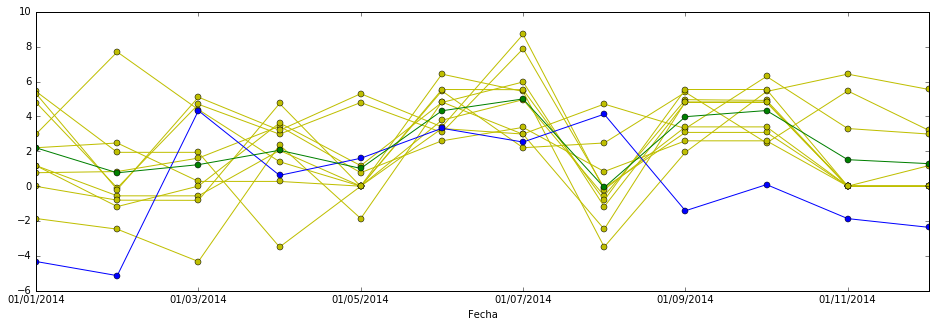

In [37]:
Predicts10 = Predicts
MeanPredictions10 = MeanPredictions
MSEmean10 = MSEmean
fig10

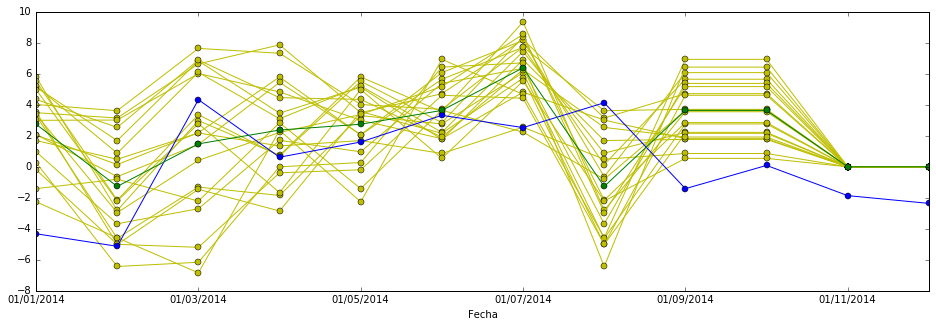

In [46]:
Predicts20 = Predicts
MeanPredictions20 = MeanPredictions
MSEmean20 = MSEmean
fig20

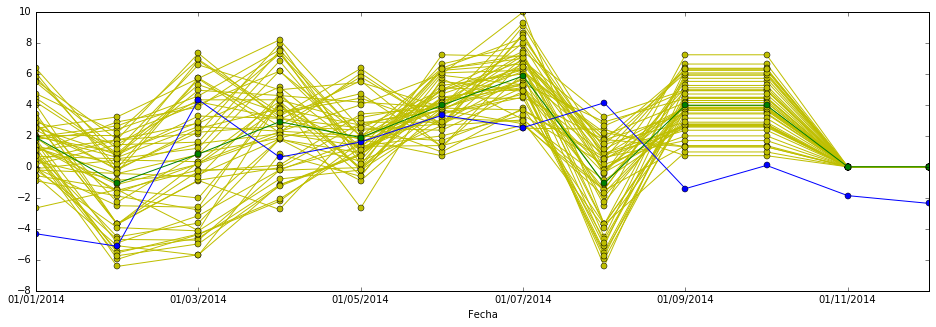

In [56]:
Predicts50 = Predicts
MeanPredictions50 = MeanPredictions
MSEmean50 = MSEmean
fig50

In [39]:
rna,mean,pred,list = Validation(ParametersList,1)

ValueError: total size of new array must be unchanged

In [94]:
rna,mean,pred,list = Validation(ParametersList,1)

In [37]:
rna,mean,pred,listP,valo = Validation(ParametersList,50)

KeyboardInterrupt: 

In [24]:
listP

array([[ -4.88249501e+00,  -4.89415098e+00,   3.88546060e+00,
         -3.05885824e-09,   3.52379131e+00,   3.88546066e+00],
       [ -2.45422122e+00,  -2.46787948e+00,   6.03876369e+00,
         -4.17887346e-13,   2.97277378e+00,   6.03876372e+00],
       [ -4.26511674e+00,  -4.26626464e+00,   2.94593801e+00,
         -4.43416628e-13,   2.39606240e+00,   2.94593802e+00],
       [  1.29865640e+00,  -8.01229222e-01,   4.87888909e+00,
         -5.51819038e-05,   4.87888909e+00,   2.77900347e+00],
       [ -1.45648308e+00,  -2.24414727e+00,   4.17312652e+00,
         -2.24408993e+00,   4.17312652e+00,   3.38546234e+00],
       [ -3.49977723e-03,  -1.34075829e+00,   4.98122165e+00,
         -1.34072301e+00,   4.98122165e+00,   3.64396313e+00],
       [  2.92611609e+00,   4.21251207e-01,   5.20109589e+00,
          4.21235317e-01,   5.20109815e+00,   2.69623327e+00],
       [ -2.02187680e+00,  -1.55035891e+00,   3.00836661e+00,
         -1.55029004e+00,   3.00836580e+00,   3.47988369e+00],


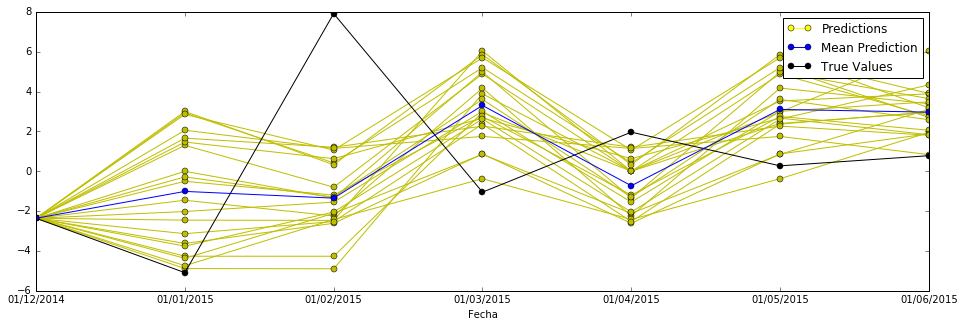

In [35]:
fig = plot_Solutions(listP,pred[0],TS)

In [30]:
mean

160.28075120121252

In [36]:
fig.savefig('TwentyPrintv2.png')